In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms, datasets
import time

In [2]:
def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs

In [3]:
class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.view(x.size(0), -1, self.dim_caps)
        return squash(outputs)

In [4]:
class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.

    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def forward(self, x):
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1)
        x_hat_detached = x_hat.detach()

        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        b = torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)

        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1)

            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat))  # alternative way
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat_detached))  # alternative way

                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)

        return torch.squeeze(outputs, dim=-2)

In [5]:
class CapsuleNet_1(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """

    def __init__(self, input_size, classes, routings):
        super(CapsuleNet_1, self).__init__()
        self.input_size = input_size
        self.classes = classes
        self.routings = routings

        # Layer 1: Just a conventional Conv2D layer
        self.conv1 = nn.Conv2d(
            input_size[0], 256, kernel_size=9, stride=1, padding=0)

        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(
            256, 256, 8, kernel_size=9, stride=2, padding=0)

        # Layer 3: Capsule layer. Routing algorithm works here.
        #self.digitcaps = DenseCapsule(in_num_caps=32*6*6, in_dim_caps=8,
        #                              out_num_caps=classes, out_dim_caps=16, routings=routings)
        self.digitcaps = DenseCapsule(in_num_caps=1486848, in_dim_caps=8,
                                      out_num_caps=classes, out_dim_caps=25, routings=routings)

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(50,2)
        #self.fc2 = nn.Linear(10,2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x, y=None):
        x = self.relu(self.conv1(x))
        x = self.primarycaps(x)
        x = self.digitcaps(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=2)
        #print(x.shape)
        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        x = self.softmax(x)
        #print(x.shape)
        #print(x)
        #length = x.norm(dim=-1)
        #print(length)
        return x

In [6]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    b = []
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
                c = (net(X).argmax(dim=1)).numpy()
                b.extend(c)
                #print(b)
                #net.train() # 改回训练模式
            else: 
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                    result = (net(X, is_training=False).argmax(dim=1)).float().sum().item()
                    c = (net(X).argmax(dim=1)).numpy()
                    b.extend(c)
                    #print(b)
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
                    result = (net(X).argmax(dim=1)).float().sum().item()
                    c = (net(X).argmax(dim=1)).numpy()
                    b.extend(c)
                    #print(b)
            n += y.shape[0]
    return b

In [7]:
class CapsuleNet_2(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """

    def __init__(self, input_size, classes, routings):
        super(CapsuleNet_2, self).__init__()
        self.input_size = input_size
        self.classes = classes
        self.routings = routings

        # Layer 1: Just a conventional Conv2D layer
        self.conv1 = nn.Conv2d(
            input_size[0], 256, kernel_size=9, stride=1, padding=0)

        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(
            256, 256, 8, kernel_size=9, stride=2, padding=0)

        # Layer 3: Capsule layer. Routing algorithm works here.
        #self.digitcaps = DenseCapsule(in_num_caps=32*6*6, in_dim_caps=8,
        #                              out_num_caps=classes, out_dim_caps=16, routings=routings)
        self.digitcaps = DenseCapsule(in_num_caps=1486848, in_dim_caps=8,
                                      out_num_caps=classes, out_dim_caps=20, routings=routings)

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(40,10)
        self.fc2 = nn.Linear(10,2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x, y=None):
        x = self.relu(self.conv1(x))
        x = self.primarycaps(x)
        x = self.digitcaps(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=2)
        #print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(x)
        #print(x.shape)
        #print(x)
        #length = x.norm(dim=-1)
        #print(length)
        return x

In [8]:
import pandas as pd
import numpy as np
import cv2
data_1 = pd.read_csv("naocuzchuli1.csv",sep=",", engine='python', encoding='utf-8')
data = pd.read_csv("数据标注.csv",sep=",", engine='python', encoding='utf-8')

In [9]:
def findname(name):
    for i in range(0,len(name)):
        #print(name[i][0])
        if(name[i][0] == '2' and name[i][1] == '-'):
            file_dir1 = file_dir+"/"+name[i]
            break
        else:
            if(name[i][0] == '5'and name[i][1] == '-'):
                file_dir1 = file_dir+"/"+name[i]
                #print(file_dir1)
                break
            else:
                if(name[i][0] == '6'and name[i][1] == '-'):
                    file_dir1 = file_dir+"/"+name[i]
                    break
                else:
                    if(name[i][0] == '3'and name[i][1] == '-'):
                        file_dir1 = file_dir+"/"+name[i]
                        break
                    else:
                        if(name[i][0] == '9'and name[i][1] == '-'):
                            file_dir1 = file_dir+"/"+name[i]
                            break
    return file_dir1

In [10]:
size_n = 100
def readimage(file_dir,name,size_n):
    character_address = file_dir+"/"+name
    #print(character_address)
    d = cv2.imread(character_address,0)
    d = cv2.resize(d, (size_n, size_n))
    return d
#d = readimage(file_dir1,name_1[0],size_n)

In [11]:
import os
X_data = []
path_label=[]
for h in range(0,len(data["ID"])):
    file_dir='./'+data["ID"][h]
    print(file_dir)
    # ⽬录下⾯的所有⽂件名
    name = os.listdir(file_dir)
    file_dir2 = findname(name)
    name_1 = os.listdir(file_dir2)
    #print(h)
    #data.append
    #print(name_1)
    #print(file_dir2)
    for i in range(0,20):
        if i == 0:
            #print(file_dir2)
            d = readimage(file_dir2,name_1[i],size_n)
        else:
            c = readimage(file_dir2,name_1[i],size_n)
            d = np.hstack((d,c))
    #print(d.shape)
    d = np.reshape(d, (400, 500))
    X_data.append(d)
    path_label.append(data["Lable"][h])

./MR201802210163-Wu HuaHao
./MR201706120215-LiangYuQing
./MR201602290243-Liang QiPan
./MR201803090487-HuangTianDi
./MR201710230147-HuangJiangQuan
./MR2017062901390-LinGen You
./MR201707060266-ChenGuiYing
./MR201806250211-HuangHuiZhong
./MR201806040279-Li JinRong
./MR202103160080-Chen LianDing
./MR201807080094-He Zhong
./MR201708080222-Li GuiFeng
./MR202109160378-Liang YouDi
./MR201802200016-ZhaoDongSheng
./MR201803140073-Fang LiChang
./MR201711160167-Huang ZhiRong
./MR201709170104-LiangSuZhen
./MR202110280279-Yang XiTian
./MR201803170300-Huang GenFa
./MR201805060354-XieShengYu
./MR201812090066-Lin Nong
./MR201810030079-Huang QiDing
./MR201806070184-ZhouLiBo
./MR201811040118-Pan YiYou
./MR202204270343-Huang BingQiang
./MR201807130152-Zhang SheXie
./MR201901140071-Xiao BaoXi
./MR202007040281-Yin CaiDi
./MR201907170393-Ou FuTai
./MR201808280243-Lin ShiMei
./MR201808150286-Huang ZhengLian
./MR201902140144-Zhou RuiQiu
./MR201905270177-Lu SongMao
./MR201908300389-Huang YanChun
./MR2019092402

In [12]:
X_data_1 = np.array(X_data)
X_data_1 = X_data_1.reshape(X_data_1.shape[0],1 ,X_data_1.shape[1], X_data_1.shape[2])
X_data_1.shape

(192, 1, 400, 500)

In [13]:
list = []
list_1 = []
for i in range(0,len(data)):
    for j in range(0,len(data_1)):
        if data["姓名"][i]==data_1["姓名"][j]:
            list.append(j)
            list_1.append(data["Lable"][i])
dataset = data_1.iloc[list]
#dataset = dataset.drop(["姓名"],axis=1)

In [14]:
#dataset_1 = data_1.iloc[list]

In [15]:
#dataset_1

In [16]:
#dataset

In [17]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
#categorical_labels = to_categorical(y_test, num_classes=2)
#print(categorical_labels)
X_train, X_test, y_train, y_test = train_test_split(dataset, list_1, test_size=0.2)
#Xtrain = np.array(X_train)
#Xtext = np.array(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#print(Xtrain.shape)
#print(Xtext.shape)

In [18]:
list3 = []
for i in range(0,len(X_test)):
    #print(X_test["姓名"][X_test.index[i]])
    for j in range(0,len(data)):
        if(data["姓名"][j] == X_test["姓名"][X_test.index[i]]):
            list3.append(j)
#list3

In [19]:
X_test_DL = X_data_1[list3]
X_train = X_train.drop(["姓名"],axis=1)
X_test = X_test.drop(["姓名"],axis=1)
Xtrain = np.array(X_train)
Xtext = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
X_test

,性别,年龄,住院时间,吸烟,饮酒,消化性溃疡史,TIA/卒中史,糖尿病,高血压分级,房颤,...,C反应蛋白(mg/l),血清白蛋白水平(g/l),载脂蛋白a1(g/l),载脂蛋白b,血小板水平（*109）,白细胞水平（*109）,中性粒细胞百分比,纤维蛋白原,糖化血红蛋白,颈动脉粥样硬化
564,0,59,7,1,3,0,0,0,3,0,...,0.56,40.4,0.98,0.93,241,6.8,49.9,2.88,6.0,1
170,0,52,3,0,2,0,0,0,3,0,...,1.72,47.0,1.63,1.04,264,9.3,76.4,3.02,5.3,0
169,0,71,5,0,0,0,0,0,3,0,...,0.48,41.0,1.20,1.09,250,7.9,84.6,3.31,5.2,1
199,0,65,8,0,0,0,0,0,3,0,...,1.22,38.5,0.98,0.88,200,6.4,58.3,2.92,5.7,1
205,0,51,6,1,3,0,0,0,1,0,...,0.73,41.6,1.22,0.96,256,8.4,68.3,2.28,5.9,1
165,0,60,6,0,2,0,0,1,3,0,...,6.34,46.7,1.21,0.84,310,10.5,68.9,3.48,6.9,0
504,1,74,6,0,0,1,0,0,3,0,...,0.86,40.3,1.33,1.37,277,6.4,66.5,2.81,5.9,1
553,0,72,9,1,1,0,0,1,3,0,...,72.07,37.5,0.87,0.76,204,5.0,70.5,3.87,11.7,1
146,1,66,5,0,0,0,0,0,3,0,...,9.27,41.3,1.15,1.12,225,7.8,67.5,3.55,6.2,1
286,1,77,6,0,0,0,0,0,1,0,...,10.42,39.2,1.08,1.41,217,9.8,61.8,4.02,6.3,1


training in 8.35 seconds
[1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0
 1 0]
[1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0
 0 0]
26.0  Correct in total :  39.0 	 66.66666666666666 %
0.6760626066315556


<ipython-input-21-940c5b2af303>:40: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr) #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数


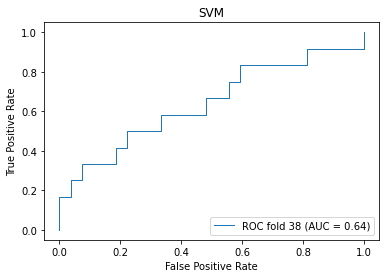

[[ 7.15890911e-01  2.72292434e-02  7.73760760e-02  8.92132371e-01
   4.08116139e-01 -6.51655520e-01  0.00000000e+00 -1.03245903e+00
   1.90703439e-01  8.83282844e-01  1.00368772e+00 -7.50699658e-03
  -5.75222007e-03 -6.16760067e-02 -1.57409134e-02  2.91117219e-03
   5.82819593e-01 -1.22045584e+00  3.64955727e-02  1.09327140e+00
  -3.25297756e-02  1.54990121e-03 -5.20077396e-02  7.30066096e-01
   5.04863031e-01  4.96118649e-03 -1.74574238e-01  4.28385602e-05
  -3.06106092e-01  4.02506584e-01  6.08309734e-01]]


In [21]:
import timeit
import numpy as np  
from scipy import interp  
import matplotlib.pyplot as plt
from sklearn import metrics
  
from sklearn import svm, datasets  
from sklearn.metrics import roc_curve, auc  
#from sklearn.cross_validation import StratifiedKFold  

start_time = timeit.default_timer()
clf = svm.SVC(kernel='linear',probability=True)
clf.fit(X_train, y_train)
end_time = timeit.default_timer()
k = end_time - start_time
print("training in %s seconds" % round(end_time - start_time,2))
count = 0.0;
crct = 0.0
start_time = timeit.default_timer()
print (clf.predict(X_test))
#print clf.predict_proba(test[:,:-1]) 
#print clf.predict_proba(test[:,:-1])
print (y_test)
res = clf.predict(X_test)
for i in range(len(y_test)):
    count += 1
    if res[i] == y_test[i]:
        crct += 1
end_time = timeit.default_timer()
id = 15
time = k + (end_time - start_time)
number = crct/count

print (crct,' Correct in total : ',count,'\t',crct/count * 100,'%')
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)  
all_tpr = [] 
probas_ = clf.predict_proba(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  
mean_tpr += interp(mean_fpr, fpr, tpr) #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数  
mean_tpr[0] = 0.0  #初始处为0  
roc_auc = auc(fpr, tpr)
print (metrics.f1_score(y_test, probas_[:, 1].round(), average='weighted'))  
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)) 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('SVM')  
plt.legend(loc="lower right")  
plt.show() 
print(clf.coef_)

In [22]:
testset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test_DL), torch.FloatTensor(y_test))
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=1)

In [23]:
def load_model(save_name, optimizer, model):
    model_data = torch.load(save_name)
    model.load_state_dict(model_data['model_dict'])
    optimizer.load_state_dict(model_data['optimizer_dict'])
    print("model load success")

In [24]:
path = "./model_image_1/model_1.pkl"
batch_size, lr, num_epochs = 5, 0.001, 10
net = CapsuleNet_1(input_size=[1, 400, 500], classes=2, routings=2)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#loss = nn.CrossEntropyLoss()
load_model(path, optimizer, net)

model load success


In [25]:
T1_result = evaluate_accuracy(testloader, net)

In [26]:
T1_result

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0]

In [27]:
path = "./model_image_2/model_1.pkl"
batch_size, lr, num_epochs = 5, 0.001, 10
net = CapsuleNet_2(input_size=[1, 400, 500], classes=2, routings=2)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#loss = nn.CrossEntropyLoss()
load_model(path, optimizer, net)

model load success


In [28]:
T2_result = evaluate_accuracy(testloader, net)

In [29]:
T2_result

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0]

In [30]:
#计算最终结果
result_fin = []
for i in range(0,len(res)):
    T = 0
    F = 0
    re = 0
    if(res[i] == 1):
        T = T+1
    else:
        F = F+1
    if(T1_result[i] == 1):
        T = T+1
    else:
        F = F+1
    if(T2_result[i] == 1):
        T = T+1
    else:
        F = F+1
    if(T > 1):
        re = 1
    else:
        re = 0
    result_fin.append(re)
#y_test 

In [31]:
result_fin

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0]

In [33]:
#指标矩阵
from sklearn.metrics import classification_report
target = ['class1', 'class2']
print(classification_report(y_test, result_fin, target_names=target))

              precision    recall  f1-score   support

      class1       1.00      1.00      1.00        27
      class2       1.00      1.00      1.00        12

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



<ipython-input-36-418ee40fc55d>:3: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr) #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数


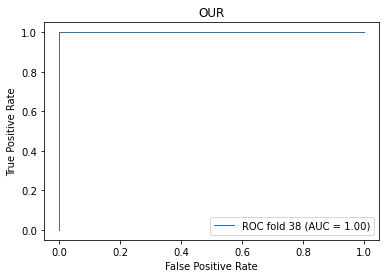

In [36]:
#AUC
fpr, tpr, thresholds = roc_curve(y_test, result_fin)  
mean_tpr += interp(mean_fpr, fpr, tpr) #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数  
mean_tpr[0] = 0.0  #初始处为0  
roc_auc = auc(fpr, tpr)
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)) 
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('OUR')  
plt.legend(loc="lower right")  
plt.show() 